<a href="https://colab.research.google.com/github/neoalwayz/Instance-Segmentation-Dectectron2/blob/main/Instance_Segmentation_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [4]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train4", {}, "train2016.json", "/content/")
register_coco_instances("my_dataset_val4", {}, "val2016.json", "/content/")



## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train4",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
#%load_ext tensorboard
#%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [6]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[02/27 09:19:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Then, we randomly select several samples to visualize the prediction results.

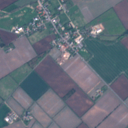

In [7]:
im = cv2.imread("/content/COCO_train2016_000000100000.jpg")
cv2_imshow(im)


Our Test-Function: 

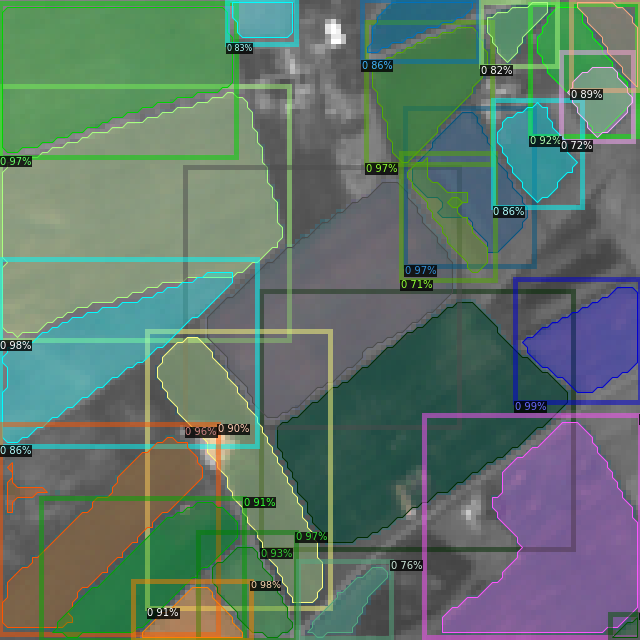

In [28]:
from detectron2.utils.visualizer import ColorMode
im = cv2.imread("/content/COCO_train2016_000000100002.jpg")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],#metadata=balloon_metadata, 
    scale=5, instance_mode=ColorMode.IMAGE_BW , # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

**Generation of Mask of the predicted Image**

In [54]:
#
mask_array = outputs['instances'].pred_masks.to("cpu").numpy()
num_instances = mask_array.shape[0]
mask_array = np.moveaxis(mask_array, 0, -1)
mask_array_instance = []
output = np.zeros_like(im) #black
#print('output',output)
for i in range(num_instances):
    mask_array_instance.append(mask_array[:, :, i:(i+1)])
    output = np.where(mask_array_instance[i] == True, 255, output)
cv2.imwrite('/content'+'/'+'mask'+'.jpg',output)#mask
#cv2.imwrite(mask_path+'/'+item+'.jpg',output)#mask

True

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [58]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val4", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val4")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[02/27 11:36:01 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[02/27 11:36:01 d2.data.datasets.coco]: Loaded 2 images in COCO format from val2016.json
[02/27 11:36:01 d2.data.build]: Distribution of instances among all 1 categories:
|   category    | #instances   |
|:-------------:|:-------------|
| agfields_si.. | 69           |
|               |              |
[02/27 11:36:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/27 11:36:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/27 11:36:01 d2.data.common]: Serializing 2 elements to byte tensors and concatenating them all ...
[02/27 11:36:01 d2.data.common]: Serialized dataset takes 0.02 MiB
[02/27 11:36:01 d2.evaluation.evaluator]: Start inference on 2 batches
[02/27 11:36:02 d2.evaluation.evaluator]: Tota